# Run Configuration

In [13]:
##################################
submission_run = True # if true, overrides the next three to false and outputs a submission.csv
perform_sweep = False  # If true, perform extensive hyperparameter sweep using wandb
enable_wandb = True   # enables internet connection with wandb. False overrides perform_sweep
enable_vis = True      # show visualizations and analysis of results
dataset_name = 'XL'    # different sets of features from the contest data. from ['static','reduced','XL']
n_splits = 1           # how many models to train
weeks_per_split = 40   # number of weeks in each models sampled set
test_size = 8          # for each cv fold, how many weeks are test
k = 3                  # folds for inner cv
cv_distance = 5        # how many weeks to offset each cv fold
count = 30             # number of steps of baysian hyperparameter opt
start_with = 0         # in case you've already run the first couple
seed = 0               # for any random processes
with_stacker = False    # train a LogisticRegression model to combine ensemble results; otherwise use mean
##################################

if submission_run:
    perform_sweep, enable_wandb, enable_vis = False, False, False
    
ensemble_name = f"Ensemble_{dataset_name}_{n_splits}_{weeks_per_split}_{test_size}_{k}_{seed}"

# Imports

In [14]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np

import os
from glob import glob
from random import shuffle
import copy
import random
from tqdm import tqdm
import pickle
import json


import shap

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer, enable_halving_search_cv
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingRandomSearchCV, HalvingGridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics

from imblearn.over_sampling import SMOTE 

import lightgbm as lgb

import matplotlib.pyplot as plt

from collections import namedtuple
# connect wandb
# ! pip install wandb -Uq

import wandb
from kaggle_secrets import UserSecretsClient


import functools

# Load Data

In [15]:
# load in our descriptions of the datasets
with open('/kaggle/input/desc-and-1st-params/descriptions.pkl', 'rb') as f:
    datasets = pickle.load(f)
    
# we also need to output this file, or it wont be retained when we update our input dataset
with open('descriptions.pkl', 'wb') as f:
    pickle.dump(datasets, f)

In [16]:
# DataLoader class and helpers

# holds data within DataLoader
class Split:
    def __init__(self, name):
        self.name = name
        self.WEEK_NUM = None
        self.X = None
        self.y = None

        
class DataLoader:
    def __init__(self, descriptions=None, name=None, file_type='.csv', train_fraction=0.8):
        folder = {'.csv':'csv_files', '.parquet':'parquet_files'}
        self.dataPath = dataPath = f"/kaggle/input/home-credit-credit-risk-model-stability/{folder[file_type]}"
        self.train_fraction=train_fraction
        self.file_type=file_type
        self.descriptions=descriptions[name]
        self.name=name
        
        self.train = None
        self.test = None
        self.submit = None
        return
    
    
    def set_dtypes(self, df):
        # reduce size of df and standardize
        for col in df.columns:
            # last letter of column name will help you determine the type
            if col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float32).alias(col))
            elif col[-1] =="D" or col =="date_decision":
                df = df.with_columns(pl.col(col).cast(pl.Date).alias(col))
                
            # convert strings to categorical
            if df[col].dtype in [pl.String]:
                df = df.with_columns(pl.col(col).cast(pl.Categorical).alias(col))
                
            # standardize all numeric to Float32
            elif df[col].dtype in [pl.Float64, pl.Int64, pl.Boolean]:
                df = df.with_columns(pl.col(col).cast(pl.Float32).alias(col))
        return df
    
    
    def handle_dates(self, df):
        # modified from code created by Farukcan Saglam for this competition
        for col in df.columns:
            if col[0].islower and col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
        df = df.drop("date_decision",)
        return df
    
    def WEEK_NUM_split(self, df):
        split_idx = int(len(df)*self.train_fraction)
        split_week = df.sort('WEEK_NUM').row(split_idx, named=True)['WEEK_NUM']
        
        train_ids = df.filter(pl.col('WEEK_NUM') <= split_week)['case_id']
        test_ids = df.filter(pl.col('WEEK_NUM') > split_week)['case_id']
        
        return train_ids, test_ids
        
    
    def __iter__(self):
        for attr in ["train", "test", "submit"]:
            val = self.__dict__[attr]
            yield attr, val
            
            
    def load_single_df(self, name, depth=0, features=None, feature_types=None, description=None):
        print(f"Loading {name}")
        results = []
        for split in ["train", "test"]:
            # FIRST, load all files which match name
            # load all partitions
            df_list = []
            for file in glob(f"{self.dataPath}/{split}/{split}_{name}*"):
                if self.file_type == '.parquet':
                    df = pl.read_parquet(file, infer_schema_length=60000).pipe(self.set_dtypes)
                else:
                    df = pl.read_csv(file, infer_schema_length=60000).pipe(self.set_dtypes)
                df_list.append(df)
            
            # special case: treating the tax registries as partitions of same file
            if name == "tax_registry":
                name_map ={"M":"employerM", "A":"taxdeductionA","D":"processdateD"}
                for i in range(len(df_list)):
                    # standardize their names to allow concat
                    standard_cols = [name_map[c[-1]] if c not in ['case_id', "num_group1"] else c for c in df_list[i].columns]
                    df_list[i].columns = standard_cols
                    df_list[i] = df_list[i].select(sorted(standard_cols))
            
            # standardize dtypes; if they disagree, it inferred an all-NaN float col as String
            if len(df_list)>1:
                for i, dtypes in enumerate(zip(*[df.dtypes for df in df_list])):
                    if len(set(dtypes)) > 1: # different dtypes
                        print(f"dtype mismatch: {name}, {split}, column {df_list[0].columns[i]}, dtypes: {dtypes}. Cast all to Float32.")
                        for j in range(len(df_list)):
                            col = df_list[j].columns[i]
                            df_list[j] = df_list[j].with_columns(pl.col(col).cast(pl.Float32).alias(col))
            # combine partitions    
            df = pl.concat(df_list, how="vertical_relaxed")

            # NEXT, infer features to select if not explicitly specified
            if split == 'train':
                if name != 'base': 
                    if features is None:
                        features = [f for f in df.columns if (f[-1].isupper() and f[:-1].islower())]
                    if feature_types is not None:
                        features = [f for f in features if f[-1] in feature_types]
                    # select group features
                    for g in range(depth):
                        features.append(f'num_group{g+1}')
                    features.append('case_id')
                else: # this is the base df
                    features = df.drop('MONTH').columns
            if split == 'test' and name == 'base':
                features.remove('target')
            df = df.select(list(set(features)))
            # rename group features
            for g in range(depth):
                alias = f"{name}_group{g+1}S"
                df = df.rename({f'num_group{g+1}':alias})


            # FINALLY, if depth > 0, aggregate
            if depth > 0:
                # determine the aggregations to perform
                # NB currently, this lumps dates in with categories, and returns the most frequent (vs max)
                num_agg_list = [pl.col(f).max().name.prefix("max_") for f in df.select(cs.numeric()).drop('case_id').columns]
                cat_agg_list = [pl.col(f).drop_nulls().mode().first().name.prefix("mostfreq_") for f in df.select(~cs.numeric()).columns]
                # groupby and aggregate
                df = df.group_by("case_id").agg(num_agg_list+cat_agg_list)
            try:
                df = pl.concat([df, non_agg_features], how='horizontal')
            except:
                pass # no non_agg_features
            results.append(df)
            # now repeat for 'test' or submit df
        return results



    def load_dfs(self, descriptions=None, name=None):
        self.descriptions=descriptions or self.descriptions
        if self.descriptions is None:
            raise Error('please provide dict of dataset descriptions')
        self.name = name or self.name or 'unk_df'
        train = {}
        test = {}
        for name in tqdm(self.descriptions):
            train_df, test_df = self.load_single_df(**self.descriptions[name])
            train[name]=train_df
            test[name]=test_df
        train_base = train.pop('base')
        test_base = test.pop('base')

        # join all sets
        for dataset in train:
            train_base = train_base.join(train[dataset], how='left', on='case_id')
            test_base = test_base.join(test[dataset], how='left', on='case_id')
        
        train_base = train_base.pipe(self.handle_dates)
        test_base = test_base.pipe(self.handle_dates)

        #standardize column dtypes
        for col in train_base.drop('target').columns:
            if col not in test_base.columns:
                print(f"Removing Feature:'{col}' not found in test features.")
                train_base = train_base.drop(col)
            elif train_base.schema[col] != test_base.schema[col]:
                try:
                    test_base = test_base.cast({col:train_base.schema[col]})
                except:
                    print(f'Removing Feature: irreconcilable data types for feature {col} (train:{train_base.schema[col]}, test:{test_base.schema[col]})')
                    test_base = test_base.drop(col)
                    train_base = train_base.drop(col)
                    
        # split data, and save all. Note: this does not create validation data split
        if self.train_fraction < 1.0:
            train_ids, test_ids = self.WEEK_NUM_split(train_base)

            self.train = Split('train')
            self.train.y = train_base.filter(pl.col("case_id").is_in(train_ids)).select(pl.col(['case_id','target']))
            self.train.X = train_base.filter(pl.col("case_id").is_in(train_ids)).drop(["WEEK_NUM", "target"])
            self.train.WEEK_NUM = train_base.filter(pl.col("case_id").is_in(train_ids)).select(pl.col(['case_id','WEEK_NUM'])).cast(pl.Int32)

            self.test = Split('test')
            self.test.y = train_base.filter(pl.col("case_id").is_in(test_ids)).select(pl.col(['case_id','target']))
            self.test.X = train_base.filter(pl.col("case_id").is_in(test_ids)).drop(["WEEK_NUM", "target"])
            self.test.WEEK_NUM = train_base.filter(pl.col("case_id").is_in(test_ids)).select(pl.col(['case_id','WEEK_NUM'])).cast(pl.Int32)
            
        elif self.train_fraction == 1.0:
            self.train = Split('train')
            self.train.y = train_base.select(pl.col(['case_id','target']))
            self.train.X = train_base.drop(["WEEK_NUM", "target"])
            self.train.WEEK_NUM = train_base.select(pl.col(['case_id','WEEK_NUM'])).cast(pl.Int32)
            
            
        self.submit = Split('submit')
        self.submit.X = test_base.drop(["WEEK_NUM"])
        self.submit.WEEK_NUM = test_base.select(pl.col(['case_id','WEEK_NUM'])).cast(pl.Int32)
        print('done')
        return self

In [17]:
data = DataLoader(datasets, name=dataset_name).load_dfs()

  0%|          | 0/14 [00:00<?, ?it/s]

Loading base


  7%|▋         | 1/14 [00:00<00:10,  1.29it/s]

Loading static_0


Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
 14%|█▍        | 2/14 [00:19<02:16, 11.35s/it]

dtype mismatch: static_0, test, column deferredmnthsnum_166L, dtypes: (Float32, Categorical(ordering='physical'), Categorical(ordering='physical')). Cast all to Float32.
dtype mismatch: static_0, test, column isbidproductrequest_292L, dtypes: (Float32, Categorical(ordering='physical'), Categorical(ordering='physical')). Cast all to Float32.
Loading static_cb


 21%|██▏       | 3/14 [00:23<01:28,  8.08s/it]

Loading applprev_1


 29%|██▊       | 4/14 [01:29<05:10, 31.00s/it]

dtype mismatch: applprev_1, test, column credacc_transactions_402L, dtypes: (Float32, Float32, Categorical(ordering='physical')). Cast all to Float32.
dtype mismatch: applprev_1, test, column isdebitcard_527L, dtypes: (Float32, Float32, Categorical(ordering='physical')). Cast all to Float32.
Loading other_1
Loading tax_registry


 43%|████▎     | 6/14 [01:38<02:15, 16.95s/it]

dtype mismatch: tax_registry, test, column case_id, dtypes: (Float32, Categorical(ordering='physical'), Float32). Cast all to Float32.
dtype mismatch: tax_registry, test, column num_group1, dtypes: (Float32, Categorical(ordering='physical'), Float32). Cast all to Float32.
Loading credit_bureau_a_1
dtype mismatch: credit_bureau_a_1, train, column contractsum_5085717L, dtypes: (Float32, Categorical(ordering='physical'), Categorical(ordering='physical'), Categorical(ordering='physical')). Cast all to Float32.


 50%|█████     | 7/14 [04:10<06:18, 54.01s/it]

dtype mismatch: credit_bureau_a_1, test, column annualeffectiverate_63L, dtypes: (Categorical(ordering='physical'), Categorical(ordering='physical'), Float32, Float32, Float32). Cast all to Float32.
dtype mismatch: credit_bureau_a_1, test, column nominalrate_281L, dtypes: (Float32, Categorical(ordering='physical'), Float32, Float32, Float32). Cast all to Float32.
dtype mismatch: credit_bureau_a_1, test, column numberofinstls_320L, dtypes: (Float32, Categorical(ordering='physical'), Float32, Float32, Categorical(ordering='physical')). Cast all to Float32.
dtype mismatch: credit_bureau_a_1, test, column numberofoutstandinstls_59L, dtypes: (Float32, Categorical(ordering='physical'), Float32, Float32, Categorical(ordering='physical')). Cast all to Float32.
dtype mismatch: credit_bureau_a_1, test, column periodicityofpmts_837L, dtypes: (Float32, Categorical(ordering='physical'), Float32, Float32, Categorical(ordering='physical')). Cast all to Float32.
dtype mismatch: credit_bureau_a_1, test

 57%|█████▋    | 8/14 [04:11<03:54, 39.14s/it]

Loading deposit_1


 64%|██████▍   | 9/14 [04:12<02:20, 28.07s/it]

Loading person_1


 71%|███████▏  | 10/14 [05:16<02:34, 38.55s/it]

Loading debitcard_1


 79%|███████▊  | 11/14 [05:17<01:22, 27.35s/it]

Loading applprev_2


 86%|████████▌ | 12/14 [05:27<00:44, 22.40s/it]

Loading person_2


 93%|█████████▎| 13/14 [05:45<00:21, 21.03s/it]

Loading credit_bureau_b_2


100%|██████████| 14/14 [05:46<00:00, 24.73s/it]


Removing Feature:'max_interestrate_508L' not found in test features.
Removing Feature:'max_prolongationcount_599L' not found in test features.
done


In [18]:
# test
data.train.X = data.train.X.drop('sex_738L')
data.test.X = data.test.X.drop('sex_738L')
data.submit.X = data.submit.X.drop('sex_738L')

# Create CV splits for each model

In [19]:
class WeekSplit:
    def __init__(self, n_splits, weeks_per_split=2, test_size=2, cv_distance=1, seed=0):
        self.splits = None # this will save the case_ids for each split as (train_ids, val_ids) tuples
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.weeks_per_split = weeks_per_split
        self.cv_distance=cv_distance
        return
    
    
    def split(self, X, WEEK_NUM, k=3):
        max_week = WEEK_NUM['WEEK_NUM'].max() 
        weeks_per_split = self.weeks_per_split
        weeks_per_val = self.test_size
        weeks_per_train = weeks_per_split-weeks_per_val-(k-1)*self.cv_distance
        
        random.seed(self.seed) # seed rng
        # we want to make sure each week_num is used at least once,
        # while also ensuring no repeats within a split
        week_splits = [[] for _ in range(self.n_splits)]
        while min([len(s) for s in week_splits]) < weeks_per_split: #loop until all splits are at least the min length
            all_weeks = list(range(max_week+1))
            shuffle(all_weeks)
            new_additions = [all_weeks[i::self.n_splits] for i in range(self.n_splits)]
            week_splits = [old+new for old, new in zip(week_splits, new_additions)] 
            week_splits = [sorted(list(set(n[:weeks_per_split]))) for n in week_splits]# list(set()) ensures unique
        self.week_splits = week_splits
        
        CV_week_splits = []
        for w in week_splits:
            cv = []
            for i in range(0,k*self.cv_distance, self.cv_distance):
                train_weeks=w[i:weeks_per_train+i]
                val_weeks = w[weeks_per_train+i:weeks_per_train+weeks_per_val+i]
                cv.append((train_weeks, val_weeks))
            CV_week_splits.append(cv)

        self.CV_week_splits = CV_week_splits
        random.seed() # return to random
        
        # now that we have splits by WEEK_NUM, save the associated row indices
        week_by_idx = WEEK_NUM.with_row_index().select(['index', 'WEEK_NUM'])
        CV_id_splits = []
        for cv in self.CV_week_splits:
            ids = []
            for (train_weeks, val_weeks) in cv:
                train_ids = week_by_idx.filter(pl.col("WEEK_NUM").is_in(train_weeks))['index'].to_numpy().ravel()
                val_ids = week_by_idx.filter(pl.col("WEEK_NUM").is_in(val_weeks))['index'].to_numpy().ravel()
                ids.append((train_ids, val_ids))
            CV_id_splits.append(ids)
        self.CV_splits = CV_id_splits
        
        # for each final model, we want to train on data from all weeks
        # excluding the last few, which are not in any CV train splits
        self.full_splits = []
        for train_weeks in week_splits:
            train_ids = week_by_idx.filter(pl.col("WEEK_NUM").is_in(train_weeks))['index'].to_numpy().ravel()
            self.full_splits.append(train_ids)
        return self.CV_splits, self.full_splits

The CV_split_ids further break up the data subsets for each model into cross validation splits, which is useful for hyperparameter search or evaluation. For the final model, use full_split_ids to train on all of a models data.

In [20]:
ws = WeekSplit(n_splits=n_splits, weeks_per_split=weeks_per_split, 
               test_size=test_size, cv_distance = cv_distance, seed=seed)
CV_split_ids, full_split_ids = ws.split(data.train.X, data.train.WEEK_NUM, k=k)

# Weights and Bias Sweep Configuration

In [21]:
# set up wandb sweep config
sweep_config = {
    'method':'bayes',
}

metric={
    'name':'avg_score',
    'goal':'maximize'
}
sweep_config['metric'] = metric

parameters_dict = {
    'boosting':{'value':'gbdt',},
    'objective':{'value':'binary',},
    'is_unbalance':{'values':[True, False],},
    'importance_type':{'value':'gain',},
    'random_state':{'value':seed,},
    'eval_metric':{'value':'auc',},
    'early_stopping_rounds':{'value':30,},
    'max_bin':{'value':50,},
    'min_data_in_leaf':{'values':[10,50,100,250,500],},
    'bagging_freq':{'value':10,},
    'bagging_frac':{'values':[i/100 for i in range(10,75)],},
    'num_leaves':{ 'values':list(range(50,250)),},
    'feature_fraction':{'values':[i/100 for i in range(25,75)],},
    'max_depth':{'values':list(range(-1,70)),},
    'learning_rate':{'values':[i/100 for i in range(1,11)],},
    'n_estimators':{'values':list(range(100,300)),},
}
sweep_config['parameters'] = parameters_dict

In [22]:
# Note: code in this cell adapted from suggestion from this issue thread:
# https://github.com/wandb/wandb/issues/5119

# wandb struggles with nested CV. This is part of a workaround to enable it.
def reset_wandb_env():
    exclude = {
        "WANDB_PROJECT",
        "WANDB_ENTITY",
        "WANDB_API_KEY",
    }
    for key in os.environ.keys():
        if key.startswith("WANDB_") and key not in exclude:
            del os.environ[key]



# train a single cv fold with a set of hyperparameters
def train(num, sweep_id, sweep_run_name, config, data, CV_ids, sweep=True):
    if sweep:
        reset_wandb_env()
        run_name = f'{sweep_run_name}-{num}'
        run = wandb.init(
            group=sweep_id,
            job_type=sweep_run_name,
            name=run_name,
            config=config,
            reinit=True
        )
        config = wandb.config
    
    # create model
    model = lgb.LGBMClassifier(boosting_type = config.boosting, objective=config.objective,
                              num_leaves=config.num_leaves, learning_rate=config.learning_rate,
                              n_estimators=config.n_estimators, max_depth=config.max_depth,
                              is_unbalance=config.is_unbalance, importance_type=config.importance_type,
                              random_state=config.random_state, eval_metric=None)

    # pull data
    train_ids, val_ids = CV_ids[num]
    X_train = data.train.X.drop(['index', 'case_id']).to_pandas().iloc[train_ids]
    y_train = data.train.y.drop(['index', 'case_id']).to_numpy().ravel()[train_ids]
    X_val = data.train.X.drop(['index', 'case_id']).to_pandas().iloc[val_ids]
    y_val = data.train.y.drop(['index', 'case_id']).to_numpy().ravel()[val_ids]

    # train
    model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)], 
              eval_names=['val'],
              eval_metric=config.eval_metric,
             )
    print("######################")
    score = list(model.best_score_['val'].items())[0][1]
    print(f'Model {i} score:', score)
    if sweep:
        # log results
        run.log({
            'score':score
        })
        run.finish()
    return score


# perform cross validation of a set of parameters for a single model
def cross_validate(data, CV_ids, k, sweep=True, config=None):
    num_folds = k

    if sweep:
        sweep_run = wandb.init()
        sweep_id = sweep_run.sweep_id or "unknown"
        sweep_url = sweep_run.get_sweep_url()
        project_url = sweep_run.get_project_url()
        sweep_group_url = f'{project_url}/groups/{sweep_id}'
        sweep_run.notes = sweep_group_url
    #     sweep_run.save()
        sweep_run_name = sweep_run.name or sweep_run.id or "unknown_2"
        sweep_run_id = sweep_run.id
        sweep_run.finish()
        wandb.sdk.wandb_setup._setup(_reset=True)
        config=dict(sweep_run.config) # params set by sweep

    else:
        sweep_id=None
        sweep_run_name = None
        
        
    metrics = []
    for num in range(num_folds):
        score = train(
            sweep_id=sweep_id,
            num=num,
            sweep_run_name=sweep_run_name,
            config=config,
            data=data,
            CV_ids=CV_ids,
            sweep=sweep
        )
        metrics.append(score)
    
    # log metric to sweep run
    avg_score = sum(metrics)/len(metrics)
    std_score = np.std(metrics)
    
    if sweep:
        # resume the sweep run
        sweep_run = wandb.init(id=sweep_run_id, resume="must")

        sweep_run.log({
            'avg_score':avg_score,
            'std_score':std_score,
        })
        sweep_run.finish()

        print("*" * 40)
        print("Sweep URL:       ", sweep_url)
        print("Sweep Group URL: ", sweep_group_url)
        print("*" * 40)
    return avg_score, std_score

In [23]:
# load in saved parameters, either to use or update after a sweep
with open('/kaggle/input/desc-and-1st-params/saved_params.json', 'r') as f:
    saved_params_dict = json.load(f)
    # convert all parameter dicts to namedtuples
    saved_params = {name:{int(model): namedtuple(f'config_{model}', params.keys())(**params) for model, params in saved_params_dict[name].items()} for name in saved_params_dict}
    

In [24]:
if enable_wandb:
    # login to wandb
    user_secrets = UserSecretsClient()
    wandb.login(
        key=user_secrets.get_secret("wandb_key"),
        relogin=True,
        verify=True
    )
    # either perform a sweep first, or skip and load results of previous sweep from api
    if perform_sweep:
        for i, CV_ids in enumerate(CV_split_ids):
            sweep_config['name'] = f"sweep_model_{i}"
            if i < start_with:
                continue
            model_name=ensemble_name+f' Model_{i}'
            wandb_train_func = functools.partial(cross_validate, data, CV_ids, k)#, sweep=False, config=params)
            sweep_id = wandb.sweep(sweep_config, project=model_name)
            wandb.agent(sweep_id, function=wandb_train_func, count=count)
            wandb.finish()
            
    # load params of this sweep or previous from wandb api
    api=wandb.Api() 
    tuned_params = {}
    for i in range(n_splits):
        sweep=api.project(f"{ensemble_name} Model_{i}").sweeps()[0]
        p_dict = sweep.best_run().config
        tuned_params[i] = namedtuple(f'config{i}', p_dict.keys())(**p_dict) # hack to let us access params as attributes
        
    # update saved_params
    saved_params[ensemble_name] = tuned_params

else:
    # load our saved params from kaggle storage
    tuned_params = saved_params[ensemble_name]
    

        
# whether or not saved_params has been updated, we need to output it again to retain it for next dataset version
with open('saved_params.json', 'w') as f:
    saved_params_dict = {name:{model:params._asdict() for model, params in saved_params[name].items()} for name in saved_params}
    json.dump(saved_params_dict, f)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Sorting runs by -summary_metrics.avg_score


# Build Ensemble

In [25]:
def get_train_mask(WEEK_NUM, week_splits):
    # return a mask where length = len(week_num) and num cols = len(week_splits)
    weeks = pd.Series(WEEK_NUM)
    mask = weeks.apply(lambda x: pd.Series([np.nan if (x in split) else 1 for split in week_splits]))
    return mask


class SplitEnsembler:
    def __init__(self, split_ids, tuned_params, seed=0):
        self.splits = None # this will save the case_ids for each split as (train_ids, val_ids) tuples
        self.models = {}
        self.split_ids = split_ids
        self.tuned_params = tuned_params
        assert len(split_ids) == len(tuned_params)
        self.k = len(split_ids)
        self.seed = seed
        self.stacker = None
        return
    
    def fit(self, X, y):
        for i in range(self.k):
            print(f'### training model {i}... ###')
            # select data
            train_ids = self.split_ids[i]
            X_train = X.drop(['index', 'case_id']).to_pandas().iloc[train_ids]
            y_train = y.drop(['index', 'case_id']).to_numpy().ravel()[train_ids]
            
            # create model with optimized params
            config = self.tuned_params[i]
            model = lgb.LGBMClassifier(
                  boosting_type = config.boosting, objective=config.objective,
                  num_leaves=config.num_leaves, learning_rate=config.learning_rate,
                  n_estimators=config.n_estimators, max_depth=config.max_depth,
                  is_unbalance=config.is_unbalance, importance_type=config.importance_type,
                  random_state=config.random_state
            )
            # train
            model.fit(X_train, y_train)
            self.models[i] = model
        print('done.')
        return self
    
    def predict_for_each(self, X):
        X_pred = X.drop(['index', 'case_id']).to_pandas()
        y_pred = []
        for i in range(self.k):
            y_pred.append(self.models[i].predict_proba(X_pred)[:,1])
        return list(zip(*y_pred))
    
    
    def fit_stacker(self, data, week_splits):
        # predict for the entire train set
        print('predicting for train set')
        preds = pd.DataFrame(self.predict_for_each(data.train.X))
        # if a model in the ensemble saw a week in training, 
        # we want to ignore its prediction for that week (replace with avg)
        mask = get_train_mask(data.train.WEEK_NUM['WEEK_NUM'], week_splits)
        preds = preds * mask
        
        preds['mean'] = preds.mean(axis=1)
        
        preds = preds.apply(lambda x: x.fillna(x['mean']), axis =1)
        preds.drop('mean', axis=1, inplace=True)
#         we now use these predictions as input features to another model
#         TODO: hyperparameter search
        print('training stacker')
        self.stacker = LogisticRegression(random_state=self.seed).fit(preds, data.train.y['target'].to_numpy().ravel())
        print('done')
        # alternatives to consider: weighting predictions by model uncertainty, or by a model linking train data distribution to model performance
        return self
    
    def predict_proba(self, X):
        X_pred = X.drop(['index', 'case_id']).to_pandas()
        preds = self.predict_for_each(X)
        
        if self.stacker is None:
            print('no stacker: returning prediction mean')
            return preds, [np.mean(l) for l in preds]
        else:
            return preds, self.stacker.predict_proba(preds)[:,1]

In [26]:
ensemble = SplitEnsembler(full_split_ids, tuned_params)

ensemble.fit(data.train.X, data.train.y)

### training model 0... ###
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26905, number of negative: 800046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.952173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65662
[LightGBM] [Info] Number of data points in the train set: 826951, number of used features: 442
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032535 -> initscore=-3.392357
[LightGBM] [Info] Start training from score -3.392357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [27]:
if with_stacker:
    ensemble.fit_stacker(data, ws.week_splits)
    ensemble.stacker.coef_

# Evaluate

In [28]:
########################################
# Evaluation tools
########################################

def plot_roc(y, y_pred):
    
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr,
                              tpr=tpr,
                              roc_auc=roc_auc,
                              estimator_name='light_gbm'
                             )
    display.plot()
    plt.show()
    
def stability_metric(y_test_pred, y_test, WEEK_NUM_test):
    df = WEEK_NUM_test.to_pandas()
    df['y_pred'] = y_test_pred
    df['y'] = y_test
    
    weeks = df.WEEK_NUM.unique()
    gini = []
    for week in weeks:
        subset = df[df.WEEK_NUM == week]
        fpr, tpr, _ = roc_curve(subset['y'], subset['y_pred'])
        gini.append(2*auc(fpr, tpr)-1)
    print('gini mean:',np.mean(gini))
    
    # fit linear model
    reg = LinearRegression().fit(np.array(weeks).reshape(-1, 1), gini)
    falling_rate = 88*min(0,reg.coef_[0])
    print('falling_rate: ',falling_rate)
    
    gini_pred = reg.predict(np.array(weeks).reshape(-1, 1))
    residuals = [g - g_pred for g, g_pred in zip(gini, gini_pred)]
    res_std = - 0.5*np.std(residuals)
    print('residual std_dev: ', res_std)
    
    final_score = np.mean(gini) + falling_rate + res_std
    print('final score:', final_score)
    
    plt.scatter(weeks, gini, color='blue')
    plt.plot(weeks, gini_pred, color='black', linewidth=3)
    plt.plot(weeks, gini_pred+2*res_std, color='black', linestyle='dashed')
    plt.plot(weeks, gini_pred-2*res_std, color='black', linestyle='dashed')
    
    plt.show()
    
    return weeks, gini

def auc_week(df):
    aucs = {}
    for col in df.columns.drop(['target']):
        fpr, tpr, _ = roc_curve(df['target'], df[col])
        aucs[col] = auc(fpr, tpr)
    return pd.Series(aucs)
    

# plot_auc_train
def plot_auc_train(train_predictions, data, week_splits):
    
    pred_df = pd.DataFrame(train_predictions)
    pred_df['WEEK_NUM'] = data.train.WEEK_NUM['WEEK_NUM']
    pred_df['target'] = data.train.y['target']
    week_auc = pred_df.groupby('WEEK_NUM').apply(auc_week, include_groups=False)
    
    # we want an indication of which weeks a model trained on
    train_weeks = get_train_mask(week_auc.index, week_splits)
    clean_week_auc = week_auc*train_weeks
    # this has not train as 1, and train as np.nan. we want to reverse this
    train_weeks = train_weeks.replace({1:np.nan, np.nan: 1})
    train_weeks = week_auc*train_weeks
    
    # set up color map
    n = len(train_predictions[0])
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.colormaps['Paired'](np.linspace(0,1,n)))

    fig, ax = plt.subplots()
    handles = []
    for i in range(n):
        h, = ax.plot(clean_week_auc.loc[:,i], label=f'Model {i}')
        handles.append(h)
        
    ax.legend(handles=handles, bbox_to_anchor=(1.05,1), loc='upper left',borderaxespad=0.)
    for i in range(n):
        ax.scatter(train_weeks.index, train_weeks.loc[:,i])
    plt.show()
    
# def clean_col_names(columns):
#     cleaned_feature_names = []
#     for feature in columns:
#         l = feature.split("_")
#         if l[0] in ['mostfreq', 'max']:
#             l = l[1:]
#         while not (l[-1][-1].isupper() and (l[-1][0].isnumeric() or l[-1][0].islower())):
#             l = l[:-1]
#         cleaned_feature_names.append('_'.join(l))
#     return cleaned_feature_names

In [29]:
if enable_vis:
    y_test = data.test.y['target'].to_numpy().ravel()
    WEEK_NUM_test = data.test.WEEK_NUM['WEEK_NUM']
    y_test_all_preds, y_test_pred = ensemble.predict_proba(data.test.X)
    y_train_all_preds, y_train_pred = ensemble.predict_proba(data.train.X)

no stacker: returning prediction mean
no stacker: returning prediction mean


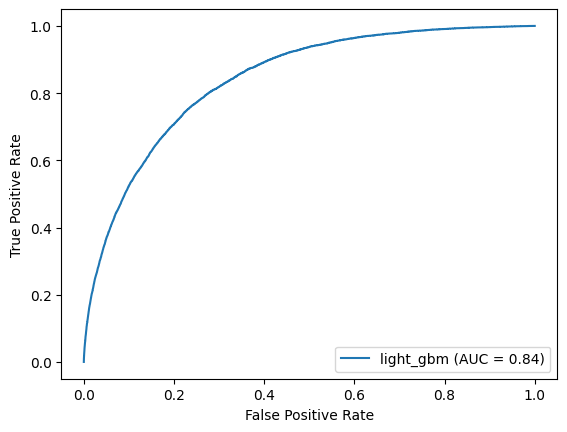

In [30]:
if enable_vis:
    plot_roc(y_test, y_test_pred)

gini mean: 0.6636500379034209
falling_rate:  0
residual std_dev:  -0.021700417759110528
final score: 0.6419496201443103


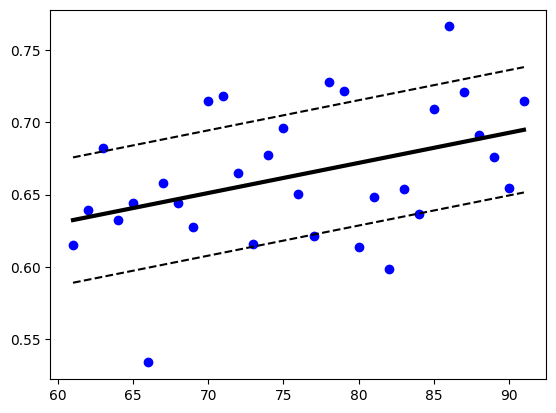

In [31]:
if enable_vis:
    stability_metric(y_test_pred, y_test, data.test.WEEK_NUM)

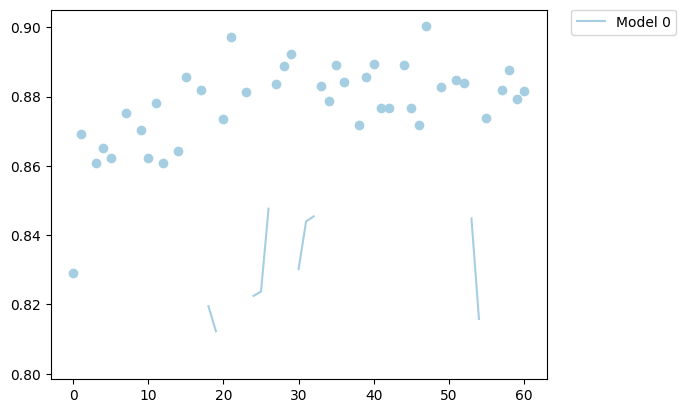

In [32]:
if enable_vis:
    plot_auc_train(y_train_all_preds, data, ws.week_splits)

In [33]:
# next steps: shap to see most important features, analysis of how biased our model is

# Submit

In [34]:
if submission_run:
    _, submit_predictions = ensemble.predict_proba(data.submit.X.select(data.train.X.columns))

    submission = pd.DataFrame({
        "case_id": data.submit.X["case_id"].to_numpy(),
        "score": submit_predictions
    }).set_index('case_id')
    submission

    submission.to_csv("./submission.csv")